In [1]:

# Pandas and Numpy for data structures and util fucntions
import scipy as sp
import numpy as np
import pandas as pd
from numpy.random import rand
pd.options.display.max_colwidth = 600

# Scikit Imports
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

# import cnn_utils as utils
# from model_evaluation_utils import get_metrics

# Matplot Imports
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

# pandas display data frames as tables
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10
from keras.engine import Model
from keras.applications import vgg16 as vgg
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

Using TensorFlow backend.


In [3]:
BATCH_SIZE = 32
EPOCHS = 40
NUM_CLASSES = 10
LEARNING_RATE = 1e-4
MOMENTUM = 0.9

In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [5]:

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.15, 
                                                  stratify=np.array(y_train), 
                                                  random_state=42)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.3)

In [7]:
Y_train = np_utils.to_categorical(y_train, NUM_CLASSES)
Y_val = np_utils.to_categorical(y_val, NUM_CLASSES)
Y_test = np_utils.to_categorical(y_test, NUM_CLASSES)

In [8]:
X_train.shape

(29750, 32, 32, 3)

In [9]:
import skimage.transform

X_train = np.array([skimage.transform.resize(x, 
                                     (48, 48), mode='constant') for x in X_train])
X_val = np.array([skimage.transform.resize(x, 
                                   (48, 48), mode='constant') for x in X_val])
X_test = np.array([skimage.transform.resize(x, 
                                    (48, 48), mode='constant') for x in X_test])

In [10]:
X_train.shape

(29750, 48, 48, 3)

In [11]:
base_model = vgg.VGG16(weights='imagenet', 
                       include_top=False, 
                       input_shape=(48, 48, 3))

In [13]:

# Extract the last layer from third block of vgg16 model
last = base_model.get_layer('block3_pool').output

- Define the Data Augmentation (ImageDataGenerator) and Learning Rate Annealer (ReduceOnPlateau) functions
- Build the model (Base Model + Flatten + Dense)
- Check model summary
- Initialize Batch Size,Number of Epochs
- Compile model
- Fit the model (We will use fit_generator since the data is fed to the model using an augmentation function
- Evaluate the model on test data

In [14]:
# Add classification layers on top of it
x = GlobalAveragePooling2D()(last)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(base_model.input, pred)

In [15]:
for layer in base_model.layers:
     layer.trainable = False

In [16]:

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['accuracy'])

In [17]:
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0   

In [18]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2)

In [19]:
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train,
                                     Y_train, 
                                     batch_size=BATCH_SIZE)

In [20]:
val_datagen = ImageDataGenerator(rescale=1. / 255,
    horizontal_flip=False)

val_datagen.fit(X_val)
val_generator = val_datagen.flow(X_val,
                                 Y_val,
                                 batch_size=BATCH_SIZE)

In [21]:
#Check final model summary
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0   

In [22]:
train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              verbose=1)

Epoch 1/40
929/929 [==============================] - 28s 30ms/step - loss: 0.2977 - accuracy: 0.9002 - val_loss: 0.2696 - val_accuracy: 0.9026
Epoch 2/40
929/929 [==============================] - 24s 25ms/step - loss: 0.2713 - accuracy: 0.9017 - val_loss: 0.2427 - val_accuracy: 0.9087
Epoch 3/40
929/929 [==============================] - 24s 26ms/step - loss: 0.2602 - accuracy: 0.9036 - val_loss: 0.2028 - val_accuracy: 0.9124
Epoch 4/40
929/929 [==============================] - 24s 25ms/step - loss: 0.2529 - accuracy: 0.9051 - val_loss: 0.2442 - val_accuracy: 0.9146
Epoch 5/40
929/929 [==============================] - 23s 25ms/step - loss: 0.2475 - accuracy: 0.9067 - val_loss: 0.2345 - val_accuracy: 0.9167
Epoch 6/40
929/929 [==============================] - 24s 26ms/step - loss: 0.2434 - accuracy: 0.9072 - val_loss: 0.1984 - val_accuracy: 0.9182
Epoch 7/40
929/929 [==============================] - 23s 25ms/step - loss: 0.2403 - accuracy: 0.9085 - val_loss: 0.2346 - val_accuracy:

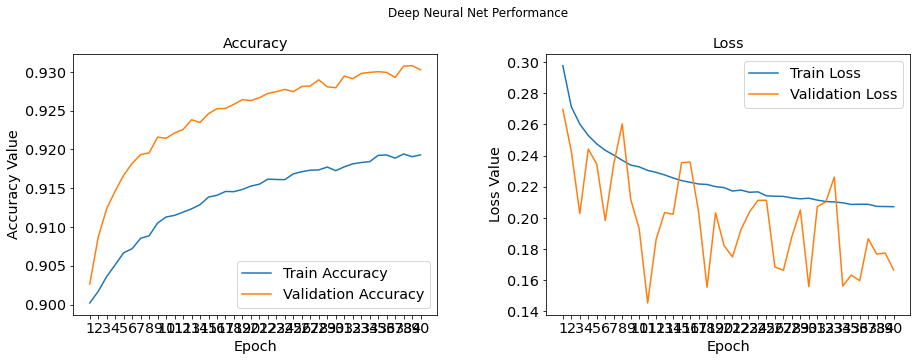

In [23]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,EPOCHS+1))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [33]:
y_pred = model.predict(X_test/255.)

In [40]:
y_test

array([[3],
       [8],
       [8],
       ...,
       [5],
       [1],
       [7]])

In [50]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
y_pred = np.argmax(pred, axis=1)
y_true = y_test.squeeze()
errors = y_pred - y_true != 0

In [51]:
y_true

array([3, 8, 8, ..., 5, 1, 7])

In [52]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.66      0.66      1000
           1       0.62      0.72      0.67      1000
           2       0.72      0.35      0.47      1000
           3       0.51      0.29      0.37      1000
           4       0.59      0.48      0.53      1000
           5       0.53      0.52      0.53      1000
           6       0.55      0.81      0.65      1000
           7       0.62      0.66      0.64      1000
           8       0.79      0.71      0.75      1000
           9       0.51      0.78      0.62      1000

    accuracy                           0.60     10000
   macro avg       0.61      0.60      0.59     10000
weighted avg       0.61      0.60      0.59     10000



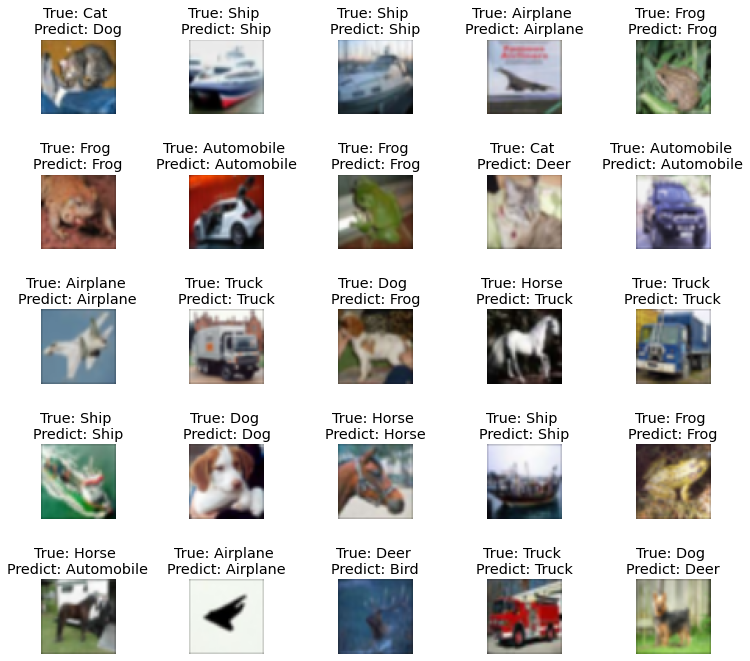

In [53]:
fig, axes = plt.subplots(5, 5, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(25):
    axes[i].imshow(X_test[i])
    axes[i].set_title('True: %s \nPredict: %s' % (labels[y_true[i]], labels[y_pred[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

In [54]:
model.save('cifar10_vgg16.h5')